In [1]:
!pip3 install pandas
!pip3 install seaborn
!pip3 install --upgrade tensorflow-gpu
!pip3 install import-ipynb

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import glob
import os
import math
import pickle
import time
import sys

import import_ipynb
import VariationalAutoencoderModel

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.losses import mse
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

%matplotlib inline

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
importing Jupyter notebook from VariationalAutoencoderModel.ipynb
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


2022-08-09 11:17:33.795422: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 11:17:33.795444: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction = 0.333)
sess = tf.compat.v1.Session(config = tf.compat.v1.ConfigProto(gpu_options = gpu_options))

2022-08-09 11:17:34.760153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-09 11:17:35.606827: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-09 11:17:35.606995: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-08-09 11:17:35.607147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared obj

# BotIoT Data Pre-Processing

In [3]:
# Traffic information

path = '../botiot/'
all_files = glob.glob(os.path.join(path , '*.csv'))

files_list = []
for file in all_files:
    df = pd.read_csv(file, index_col = None, encoding = 'utf-8', sep = ',', low_memory = False)
    files_list.append(df)

df_traffic = pd.concat(files_list, axis = 0, ignore_index = True)
df_traffic = df_traffic.drop(columns=['pkSeqID', 'stime', 'flgs', 'flgs_number', 'saddr', 'sport', 'daddr', 'dport', 'category', 'subcategory'])
df_traffic['proto'] = df_traffic['proto'].map({'tcp': 1, 'arp': 2, 'udp': 3, 'icmp': 4, 'ipv6-icmp': 5})
df_traffic['state'] = df_traffic['state'].map({'REQ': 1, 'RST': 2, 'ACC': 3, 'CON': 4, 'INT': 5, 'URP': 6, 'FIN': 7, 'NRS': 8, 'ECO': 9, 'TST': 10, 'MAS': 11})

# Benign traffic

df_benign = df_traffic.query('attack == 0')

# Attacks

df_attack = df_traffic.query('attack == 1')

In [4]:
scaler = MinMaxScaler()
df_benign_norm = scaler.fit_transform(df_benign)
df_attack_norm = scaler.fit_transform(df_attack)

# Variational Autoencoder - Attack Detection

## Model

In [5]:
# Train set

len_benign = len(df_benign_norm)
len_benign_train = int(0.7 * len_benign)
X_train_VAE = df_benign_norm[:len_benign_train]

# Test set
X_benign_test = df_benign_norm[len_benign_train:]
X_attack_test = df_attack_norm
X_test_VAE = np.concatenate([X_benign_test, X_attack_test])

Y_test_VAE = np.ones(len(X_test_VAE))
Y_test_VAE[:len(X_benign_test)] = 0

In [6]:
# KL Loss function

def vae_loss(x, x_decoded_mean):
    # Compute the average MSE error, then scale it up (sum on all axes)
    
    reconstruction_loss = K.sum(K.square(x - x_decoded_mean))
    
    # Compute the KL loss
    
    kl_loss = - 0.5 * K.sum(1 + z_var - K.square(z_mean) - K.square(K.exp(z_var)), axis=-1)
    
    # Return the average loss over all 
    
    total_loss = K.mean(reconstruction_loss + kl_loss) # Total_loss = reconstruction_loss + kl_loss 
    return total_loss

# (1) Reconstruction Loss - Forces the encoder to generate latent features that minimize the reconstruction error, or else is
# penalized
# (2) KL Loss - Forces the distribution generated by the encoder to be similar to the prior probability of the input vector, 
# pushing latent feature space to normality

In [7]:
# Parameters

original_dim = X_train_VAE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

epochs = 800
learning_rate = 0.0001
batch_size = 50
anomaly_threshold = 0.042

In [8]:
# Encoder

inputs, encoder, z_var, z_mean = VariationalAutoencoderModel.vae_encoder(
    input_shape, 
    intermediate_dim, 
    latent_dim, 
    VariationalAutoencoderModel.sample)

encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 36)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 18)           666         ['encoder_input[0][0]']          
                                                                                                  
 z_mean (Dense)                 (None, 12)           228         ['dense[0][0]']                  
                                                                                                  
 z_var (Dense)                  (None, 12)           228         ['dense[0][0]']                  
                                                                                            

In [9]:
# Decoder

decoder = VariationalAutoencoderModel.vae_decoder(
    intermediate_dim,
    latent_dim,
    original_dim)

decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 z_sampling (InputLayer)     [(None, 12)]              0         
                                                                 
 dense_1 (Dense)             (None, 18)                234       
                                                                 
 dense_2 (Dense)             (None, 36)                684       
                                                                 
Total params: 918
Trainable params: 918
Non-trainable params: 0
_________________________________________________________________


In [10]:
# VAE model

outputs = decoder(encoder(inputs))

opt = optimizers.Adam(learning_rate = learning_rate, clipvalue = 0.5)

vae_model = Model(inputs, outputs, name = 'vae_mlp')
vae_model.compile(optimizer = opt, loss = vae_loss)
vae_model.summary()

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 36)]              0         
                                                                 
 encoder (Functional)        (None, 12)                1122      
                                                                 
 decoder (Functional)        (None, 36)                918       
                                                                 
Total params: 2,040
Trainable params: 2,040
Non-trainable params: 0
_________________________________________________________________


## Train

In [11]:
train_start = time.time()

results = vae_model.fit(X_train_VAE, X_train_VAE,
                        shuffle = True,
                        epochs = epochs,
                        batch_size = batch_size)

train_end = time.time()
train_time = train_end - train_start
print("Training time:", train_time)

Train on 333 samples
Epoch 1/800
333/333 [==============================] - 0s 579us/sample - loss: 386.7180
Epoch 2/800
 50/333 [===>..........................] - ETA: 0s - loss: 400.7397

2022-08-09 11:17:58.029504: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-09 11:17:58.042387: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


333/333 [==============================] - 0s 36us/sample - loss: 383.0214
Epoch 3/800
333/333 [==============================] - 0s 48us/sample - loss: 383.3830
Epoch 4/800
333/333 [==============================] - 0s 46us/sample - loss: 378.8192
Epoch 5/800
333/333 [==============================] - 0s 45us/sample - loss: 376.5595
Epoch 6/800
333/333 [==============================] - 0s 46us/sample - loss: 374.5387
Epoch 7/800
333/333 [==============================] - 0s 46us/sample - loss: 370.7114
Epoch 8/800
333/333 [==============================] - 0s 47us/sample - loss: 371.3187
Epoch 9/800
333/333 [==============================] - 0s 50us/sample - loss: 369.0499
Epoch 10/800
333/333 [==============================] - 0s 51us/sample - loss: 366.0689
Epoch 11/800
333/333 [==============================] - 0s 53us/sample - loss: 366.2480
Epoch 12/800
333/333 [==============================] - 0s 52us/sample - loss: 363.4116
Epoch 13/800
333/333 [==============================

333/333 [==============================] - 0s 55us/sample - loss: 64.2187
Epoch 188/800
333/333 [==============================] - 0s 56us/sample - loss: 64.3408
Epoch 189/800
333/333 [==============================] - 0s 51us/sample - loss: 66.6324
Epoch 190/800
333/333 [==============================] - 0s 54us/sample - loss: 62.7192
Epoch 191/800
333/333 [==============================] - 0s 54us/sample - loss: 65.3141
Epoch 192/800
333/333 [==============================] - 0s 54us/sample - loss: 63.1930
Epoch 193/800
333/333 [==============================] - 0s 54us/sample - loss: 62.3811
Epoch 194/800
333/333 [==============================] - 0s 53us/sample - loss: 62.8125
Epoch 195/800
333/333 [==============================] - 0s 53us/sample - loss: 62.1346
Epoch 196/800
333/333 [==============================] - 0s 53us/sample - loss: 61.7922
Epoch 197/800
333/333 [==============================] - 0s 55us/sample - loss: 63.2927
Epoch 198/800
333/333 [=======================

333/333 [==============================] - 0s 53us/sample - loss: 40.4182
Epoch 374/800
333/333 [==============================] - 0s 53us/sample - loss: 40.0787
Epoch 375/800
333/333 [==============================] - 0s 54us/sample - loss: 40.1487
Epoch 376/800
333/333 [==============================] - 0s 52us/sample - loss: 39.7543
Epoch 377/800
333/333 [==============================] - 0s 50us/sample - loss: 39.2329
Epoch 378/800
333/333 [==============================] - 0s 49us/sample - loss: 40.2390
Epoch 379/800
333/333 [==============================] - 0s 52us/sample - loss: 40.5604
Epoch 380/800
333/333 [==============================] - 0s 53us/sample - loss: 40.4997
Epoch 381/800
333/333 [==============================] - 0s 54us/sample - loss: 39.7026
Epoch 382/800
333/333 [==============================] - 0s 54us/sample - loss: 40.4192
Epoch 383/800
333/333 [==============================] - 0s 54us/sample - loss: 39.4217
Epoch 384/800
333/333 [=======================

333/333 [==============================] - 0s 55us/sample - loss: 33.2847
Epoch 560/800
333/333 [==============================] - 0s 53us/sample - loss: 32.7468
Epoch 561/800
333/333 [==============================] - 0s 54us/sample - loss: 32.0915
Epoch 562/800
333/333 [==============================] - 0s 54us/sample - loss: 33.1049
Epoch 563/800
333/333 [==============================] - 0s 54us/sample - loss: 32.3956
Epoch 564/800
333/333 [==============================] - 0s 57us/sample - loss: 33.2124
Epoch 565/800
333/333 [==============================] - 0s 53us/sample - loss: 32.8743
Epoch 566/800
333/333 [==============================] - 0s 53us/sample - loss: 32.5484
Epoch 567/800
333/333 [==============================] - 0s 53us/sample - loss: 31.8614
Epoch 568/800
333/333 [==============================] - 0s 51us/sample - loss: 32.1787
Epoch 569/800
333/333 [==============================] - 0s 53us/sample - loss: 32.9415
Epoch 570/800
333/333 [=======================

333/333 [==============================] - 0s 54us/sample - loss: 27.8253
Epoch 746/800
333/333 [==============================] - 0s 52us/sample - loss: 28.1434
Epoch 747/800
333/333 [==============================] - 0s 53us/sample - loss: 28.1938
Epoch 748/800
333/333 [==============================] - 0s 54us/sample - loss: 28.5556
Epoch 749/800
333/333 [==============================] - 0s 53us/sample - loss: 28.2296
Epoch 750/800
333/333 [==============================] - 0s 54us/sample - loss: 28.3753
Epoch 751/800
333/333 [==============================] - 0s 54us/sample - loss: 28.3328
Epoch 752/800
333/333 [==============================] - 0s 52us/sample - loss: 28.1454
Epoch 753/800
333/333 [==============================] - 0s 53us/sample - loss: 27.6730
Epoch 754/800
333/333 [==============================] - 0s 54us/sample - loss: 28.2127
Epoch 755/800
333/333 [==============================] - 0s 55us/sample - loss: 28.7190
Epoch 756/800
333/333 [=======================

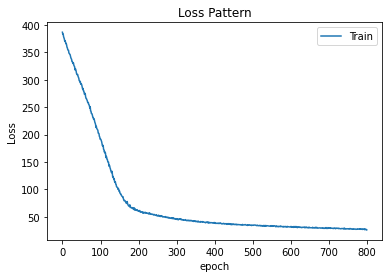

In [12]:
plt.plot(results.history['loss'])
plt.title('Loss Pattern')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Test'], loc='upper right');
plt.show()

## Test

In [13]:
X_train_pred = vae_model.predict(X_train_VAE)
error_vector = VariationalAutoencoderModel.get_error_term(X_train_pred, X_train_VAE, _rmse=False)
error_thresh = anomaly_threshold

# Measure the error between the train set and its output and generates an error vector representing the error of each term
# Find an extreme value on the vector to use as the error threshold

/home/andressa.amaral/.local/lib/python3.7/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [14]:
test_start = time.time()

X_pred_VAE = vae_model.predict(X_test_VAE)

test_end = time.time()
test_time = test_end - test_start
print("Testing time:", test_time)

# If the error of the vector is higher than the defined threshold it detects an attack

error_vector = VariationalAutoencoderModel.get_error_term(X_pred_VAE, X_test_VAE, _rmse=False)
attacks = (error_vector > error_thresh)
print(attacks)

np.count_nonzero(attacks) / len(attacks) # Percentage of attacks

Testing time: 122.2235758304596
[False  True False ...  True  True  True]


0.999989640664644

In [15]:
print(len(X_test_VAE))

3668189


## Metrics

In [16]:
sys.stdout = open("../Results/bot_iot.txt", "a")

print(" ==== Test Bot-Iot" + "Epochs:" + str(epochs) + "LR:" + str(learning_rate) + "AT:" + str(anomaly_threshold) + "Batch:" + str(batch_size) + "====")
print("Training time:" + str(train_time))
print("Testing time:" + str(test_time))
print(classification_report(Y_test_VAE, attacks, digits = 5))